In this python notebook, we use skmultilearn package as it focuses on multilabel classification. We will input the processeed data and use the training set to train the model and examine performance metrics for the test set.

### Multi-label classification strategy
We will use multi-label classification. Before we discuss which classifier to use (ex. KNN, SVM), we should consdier how we will treat the response variable first.

The "strategies" we used is listed below:
1. Binary Relevence(BR)
we seperate each genre into seperate problems (one for each genre).
However, this ignore label dependence. 
Ex. if a movie is tagged as Drama, it is likely that it is also tagged as Action. if a movie is tagged as  Horror, it is likely that it is also tagged as Romance.
If two classes of a genre (Yes/No) have very uneven sizes in the training set, the classifier will lean toward the class with higher movie number.
There is a method called a label correction strategy that can help to improve accuracy
For example, if our prediction is [Y_horror, Y_romance, Y_drama]= [1,1,0], which does not really happen in training set. We find another likely matching vector. We may change our prediction to be [1,0,1].

2. Classifier Chains (CC)
We seperate each genre into seperate problems, but include previous predictions as predictors.
For example, X is our predictor for Y_horror. Next, X, Y_horror are our predictor for Y_romance.
However, error may be propagated down the chain.

3. Label Powerset (LP)
Instead of having seperate Y_i for each genre i, we will predict only Y. Y has 2^I possible values where I is the number of genre.
For example, if Y_horror = 1, Y_romance = 0, Y_drama = 1, Y = [101]
However, imbalance of the data can be an issue.

### Classifier
For each of the strategy, we will then apply different classifier.
1. KNN
2. Naive Bayes


### Performance mertic
Please refer the details to the python notebook on performance metrics.


In [45]:
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import seaborn.apionly as sns
import datetime as dt

from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_similarity_score

from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble.rakeld import RakelD

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from skmultilearn.adapt import MLkNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from functools import partial

%matplotlib inline

In [24]:
dir_python_notebook = os.getcwd()
dir_movie_project = os.path.abspath(os.path.join(dir_python_notebook, os.pardir))
dir_data = os.path.join(dir_movie_project, 'data')

# Helper function

In [25]:
def get_metric_data_frame(Y_true_train, y_pred_train,train, model_name, strategy):
    metric_train = {} 
    metric_train["micro-f1"] = f1_score(Y_true_train, y_pred_train, average="micro")
    metric_train["weighted-f1"] = f1_score(Y_true_train, y_pred_train, average="weighted")
    metric_train["samples-f1"] = f1_score(Y_true_train, y_pred_train, average="samples")
    metric_train["macro-f1"] = f1_score(Y_true_train, y_pred_train, average="macro")
    metric_train["hamming_loss"] = hamming_loss(Y_true_train, y_pred_train)
    metric_train["subset_accuracy"] = accuracy_score(Y_true_train, y_pred_train)
    metric_train["jaccard"] = jaccard_similarity_score(Y_true_train, y_pred_train)
    
    metric_test_df_new = pd.DataFrame.from_dict(metric_train, orient='index').transpose()
    metric_test_df_new['model'] = model_name
    metric_test_df_new['strategy'] = strategy
    metric_test_df_new['train_test'] = train
    
    return metric_test_df_new

In [26]:
def get_predicion_result(X_train, Y_true_train, X_test, Y_true_test, strategy, model, model_name ):
  
    clf = BinaryRelevance(model)
    if (strategy == "Classifier Chain"):
        clf = ClassifierChain(model)
    if (strategy == "Label Powerset"):
        clf = LabelPowerset(model)   
    # train
    clf.fit(X_train, Y_true_train)

    # predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)


    metric_df = get_metric_data_frame(Y_true_train, y_pred_train, "train", model_name, strategy)
    metric_df  = metric_df.append(get_metric_data_frame(Y_true_test, y_pred_test, "test", model_name, strategy), ignore_index=True)
    
    return y_pred_train, y_pred_test, metric_df

# Load data

In [27]:
filename = dir_data + '//imdb_cluster_result_whole.csv'
data_df= pd.read_csv(filename)

In [28]:
data_df.columns

Index([u'certificates_R', u'certificates_PG', u'art.direction_1',
       u'assistant.director_1', u'cinematographer_1', u'costume.department_1',
       u'costume.designer_1', u'countries_1', u'director_1', u'distributors_1',
       u'editor_1', u'languages_1', u'make.up_1', u'miscellaneous.companies_1',
       u'miscellaneous.crew_1', u'original.music_1', u'producer_1',
       u'production.companies_1', u'production.manager_1', u'sound.crew_1',
       u'writer_1', u'special.effects.companies_1', u'cast_1', u'cast_2',
       u'cast_3', u'cast_4', u'runtimes_avg', u'rating', u'imdb_id',
       u'tmdb_id', u'Sci.Fi', u'Crime', u'Romance', u'Animation', u'Music',
       u'Adult', u'Comedy', u'War', u'Horror', u'Film.Noir', u'Western',
       u'News', u'Reality.TV', u'Thriller', u'Adventure', u'Mystery', u'Short',
       u'Talk.Show', u'Drama', u'Action', u'Documentary', u'Musical',
       u'History', u'Family', u'Fantasy', u'Game.Show', u'Sport', u'Biography',
       u'cluster_response', u

In [29]:
X_var= list(data_df.columns.values)
X_var = X_var[0:28]
X_var

['certificates_R',
 'certificates_PG',
 'art.direction_1',
 'assistant.director_1',
 'cinematographer_1',
 'costume.department_1',
 'costume.designer_1',
 'countries_1',
 'director_1',
 'distributors_1',
 'editor_1',
 'languages_1',
 'make.up_1',
 'miscellaneous.companies_1',
 'miscellaneous.crew_1',
 'original.music_1',
 'producer_1',
 'production.companies_1',
 'production.manager_1',
 'sound.crew_1',
 'writer_1',
 'special.effects.companies_1',
 'cast_1',
 'cast_2',
 'cast_3',
 'cast_4',
 'runtimes_avg',
 'rating']

In [30]:
Y_var = list(data_df.columns.values)
Y_var = Y_var[59:66]
Y_var

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7']

In [31]:
train_df = data_df[data_df[u'tmdb_id'] < 50000]
test_df = data_df[data_df[u'tmdb_id'] >= 50000]

In [32]:
train_df.shape

(24326, 66)

In [33]:
test_df.shape

(43860, 66)

In [34]:
X_train = train_df[X_var]
Y_true_train = train_df[Y_var]
X_test = test_df[X_var]
Y_true_test = test_df[Y_var]

# Prediction

## Tuning

please find cross validation example below:
http://scikit.ml/api/loading.html#cross-validation-and-train-test-splits
please find tuning parameter example below:
http://scikit.ml/api/model_estimation.html#estimating-hyper-parameter-k-for-embedded-classifiers

In [58]:
# tuning example

parameters = {
    'labelset_size': range(2, 3),
    'classifier': [LabelPowerset(), BinaryRelevance()],
    'classifier__classifier': [MultinomialNB()],
    'classifier__classifier__alpha': [0.7, 1.0],
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train, Y_true_train)

print clf.best_params_, clf.best_score_



C:\Users\Chrystal\Anaconda2\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'labelset_size': 2, 'classifier__classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'classifier': LabelPowerset(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       require_dense=[True, True]), 'classifier__classifier__alpha': 1.0} 0.187982124758


In [36]:
MODELS = {
    "Naive Bayes": GaussianNB(),
    #"Random Forest": RandomForestClassifier(random_state=0),
    #"Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=0),
    #"SVM": classifier = SVC()
    "KNN, k=5": KNeighborsClassifier(n_neighbors=5),
    "KNN, k=10": KNeighborsClassifier(n_neighbors=10),
}


In [37]:
model_keys = MODELS.keys()       
for i in range(len(model_keys)):
    model_name = model_keys[i]
    model = MODELS[model_name]
    for strategy in ['Binary Relevance','Classifier Chain','Label Powerset',]:
        y_pred_train, y_pred_test, metric_df_new = get_predicion_result(X_train, Y_true_train, X_test, Y_true_test,strategy, model, model_name )
        if i > 0 :
            metric_df = metric_df.append(metric_df_new, ignore_index=True)
        else: 
            metric_df = metric_df_new

In [38]:
metric_df

,micro-f1,jaccard,macro-f1,samples-f1,subset_accuracy,weighted-f1,hamming_loss,model,strategy,train_test
0,0.664784,0.565632,0.525055,0.660363,0.283853,0.632875,0.180542,"KNN, k=5",Label Powerset,train
1,0.539654,0.460998,0.343590,0.550919,0.222731,0.500538,0.216458,"KNN, k=5",Label Powerset,test
2,0.626818,0.543697,0.483030,0.632827,0.293102,0.596534,0.202206,"KNN, k=5",Label Powerset,train
3,0.534306,0.465344,0.344434,0.552470,0.234451,0.499406,0.219683,"KNN, k=5",Label Powerset,test
4,0.626511,0.561242,0.501615,0.639556,0.358135,0.606151,0.209893,"KNN, k=5",Label Powerset,train
5,0.517342,0.436373,0.343135,0.530928,0.187392,0.497593,0.239685,"KNN, k=5",Label Powerset,test
6,0.559225,0.435809,0.439484,0.552778,0.121598,0.554881,0.285380,Naive Bayes,Label Powerset,train
7,0.518789,0.425433,0.361153,0.527237,0.164181,0.513560,0.258384,Naive Bayes,Label Powerset,test
8,0.516194,0.402260,0.428469,0.513915,0.108115,0.529972,0.315101,Naive Bayes,Label Powerset,train
9,0.473180,0.379316,0.370462,0.481561,0.122161,0.498551,0.303133,Naive Bayes,Label Powerset,test


In [43]:
metric_df[(metric_df['strategy']== "Binary Relevance") & (metric_df['train_test']== "test")]

,micro-f1,jaccard,macro-f1,samples-f1,subset_accuracy,weighted-f1,hamming_loss,model,strategy,train_test
53,0.539654,0.460998,0.343590,0.550919,0.222731,0.500538,0.216458,"KNN, k=5",Binary Relevance,test
59,0.518789,0.425433,0.361153,0.527237,0.164181,0.513560,0.258384,Naive Bayes,Binary Relevance,test
65,0.549086,0.484711,0.303238,0.562636,0.276835,0.472725,0.191492,"KNN, k=10",Binary Relevance,test


In [50]:
def plot_metric_for_strategy(train_test, strategy, metric):
    title = metric + " for " + strategy
    metric_plot_df = metric_df[(metric_df['strategy']== strategy) & (metric_df['train_test']== train_test)]
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    ax = sns.barplot(x="model", y=metric, data=metric_plot_df)
    xt = plt.xticks(rotation=90)
    ax.set_title(title)
    plt.show()

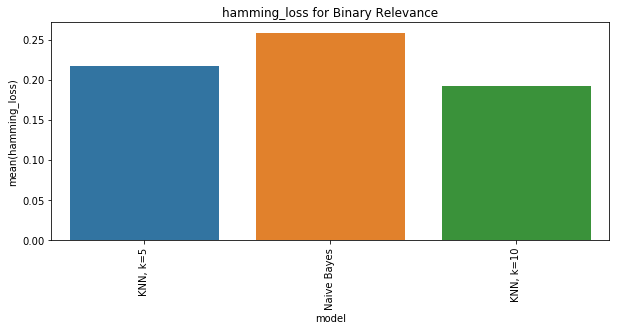

In [51]:
plot_metric_for_strategy("test","Binary Relevance","hamming_loss")

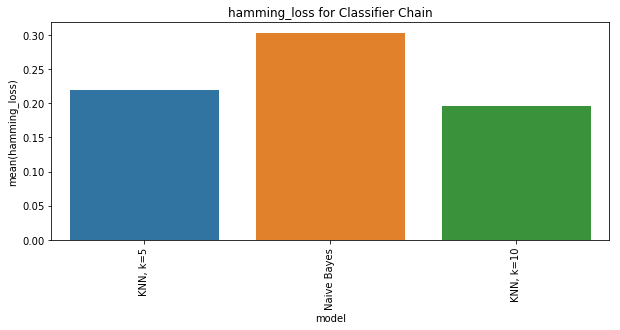

In [52]:
plot_metric_for_strategy("test","Classifier Chain","hamming_loss")

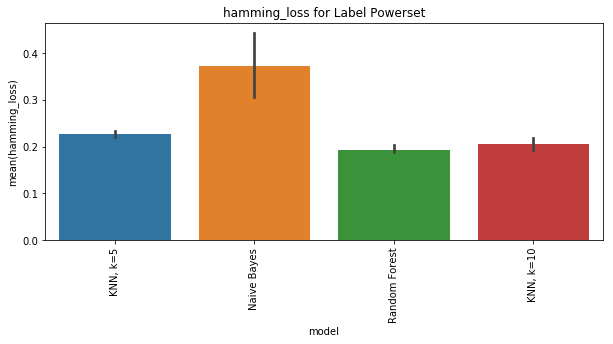

In [53]:
plot_metric_for_strategy("test","Label Powerset","hamming_loss")

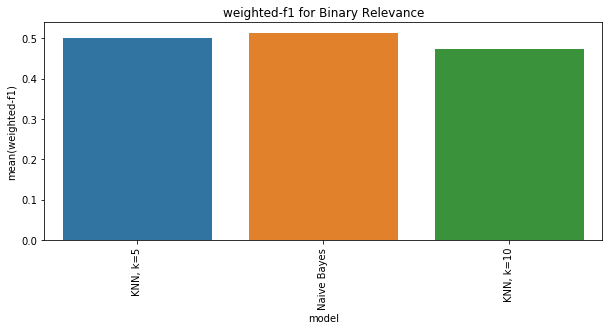

In [54]:
plot_metric_for_strategy("test","Binary Relevance","weighted-f1")

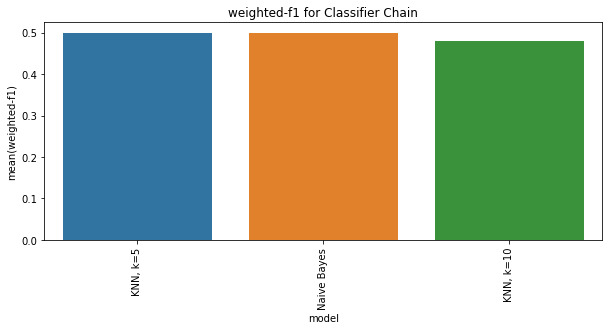

In [55]:
plot_metric_for_strategy("test","Classifier Chain","weighted-f1")

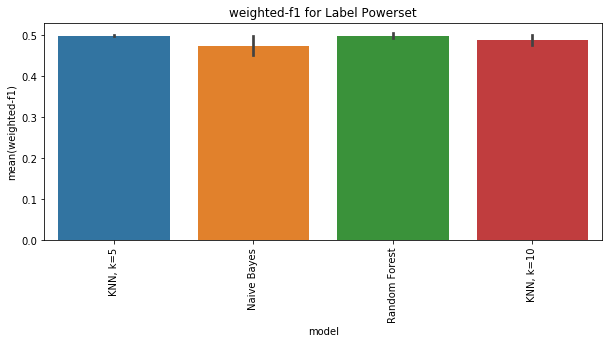

In [56]:
plot_metric_for_strategy("test","Label Powerset","weighted-f1")

# Results and Discussion

## Goal

1. We examine the performance metric for the test set among various classifiers.
    - For hamming loss, the smaller the value , the smaller the difference between predicted and true labels.

    - For F1 score, the larger the value , the smaller the difference between predicted and true labels. We will focus on weighted F1 score for now.

2. We examine the performance metric for each strategy :Binary Relevance,Classifier Chain,Label Powerset.

3. We will look into the performance metric for labels with more movies vs labels with fewer moviews.
    - We can examine the difference between F1 score for macro average and micro average. If the micro-average result is significantly lower than the macro-average one, it means that we have some gross misclassification in the most populated labels, whereas our smaller labels are probably correctly classified. 

## 1.  Classifier with the best metric
XXXXXXX

## 2.  Strategy with the best metric
XXXXXXXXXX

## 3.  If the best method we pick favor any label of size differences
XXXXXXXXXxx